In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Objectif

Le Nutriscore est une information qui peut être utile pour comparer divers produits d'une même catégorie les uns avec les autres. Cependant, tous les produits ne disposent pas de cette information et il pourrait être intéressant de pouvoir calculer ce score à partir des indications disponibles sur les étiquettes des produits (ou même simplement en scannant le code-barre).

Nous allons donc essayer de calculer le nutriscore ou le nutrigrade en nous basant sur les données disponibles sur l'étiquette d'un produit.

# Le jeu de données

> **A FAIRE**

Le jeu de données complet fait plus de 5.9GB. Et il est difficile de travailler avec un tel volume de donnée, donc je vais l'explorer petit à petit (d'abord la première ligne, puis ensuite en calculant le taux de remplissage petit bout par petit bout pour pouvoir charger un dataset allégé).

In [2]:
filename = 'data/en.openfoodfacts.org.products.csv'

#### Affichons uniquement la première ligne

In [3]:
prob = pd.read_csv(filename, sep='\t', low_memory=True, nrows=1)
prob

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Regardons l'ensemble des colonnes présentes *(et leur index pour pouvoir ajuster leur type en cas de mixed-type)*

In [4]:
for i, col in enumerate(prob.columns):
    print(i, col)

0 code
1 url
2 creator
3 created_t
4 created_datetime
5 last_modified_t
6 last_modified_datetime
7 product_name
8 abbreviated_product_name
9 generic_name
10 quantity
11 packaging
12 packaging_tags
13 packaging_en
14 packaging_text
15 brands
16 brands_tags
17 categories
18 categories_tags
19 categories_en
20 origins
21 origins_tags
22 origins_en
23 manufacturing_places
24 manufacturing_places_tags
25 labels
26 labels_tags
27 labels_en
28 emb_codes
29 emb_codes_tags
30 first_packaging_code_geo
31 cities
32 cities_tags
33 purchase_places
34 stores
35 countries
36 countries_tags
37 countries_en
38 ingredients_text
39 ingredients_tags
40 allergens
41 allergens_en
42 traces
43 traces_tags
44 traces_en
45 serving_size
46 serving_quantity
47 no_nutriments
48 additives_n
49 additives
50 additives_tags
51 additives_en
52 nutriscore_score
53 nutriscore_grade
54 nova_group
55 pnns_groups_1
56 pnns_groups_2
57 food_groups
58 food_groups_tags
59 food_groups_en
60 states
61 states_tags
62 states_en
6

#### Chargeons le CSV par petit bouts pour en calculer le `taux de remplissage` puis identifier les colonnes vides ou presque vides.

Nous allons également fournir les types pour les colonnes dont pandas n'est pas certain.

In [6]:
dtypes = {
    'code': 'str',
    'abbreviated_product_name': 'str',
    'packaging_text': 'str',
    'emb_codes': 'str',
    'emb_codes_tags': 'str',
    'first_packaging_code_geo': 'str',
    'cities_tags': 'str',
    'origins': 'str',
    'origins_tags': 'str',
    'origins_en': 'str',
    'manufacturing_places': 'str',
    'manufacturing_places_tags': 'str',
    'brand_owner': 'str',
    'generic_name': 'str',
    'packaging': 'str',
    'packaging_tags': 'str',
    'packaging_en': 'str',
    'labels': 'str',
    'labels_tags': 'str',
    'labels_en': 'str',
    'purchase_places': 'str',
    'stores': 'str',
    'allergens': 'str',
    'traces': 'str',
    'traces_tags': 'str',
    'traces_en': 'str',
    'serving_size': 'str',
    'additives_tags': 'str',
    'additives_en': 'str',
    'nutriscore_grade': 'str', # /!\
    'image_url': 'str',
    'image_small_url': 'str',
    'image_ingredients_url': 'str',
    'image_ingredients_small_url': 'str',
    'image_nutrition_url': 'str',
    'image_nutrition_small_url': 'str',
    'alcohol_100g': 'float',
}

chunksize = 10000
nan_rates = []
for chunk in pd.read_csv(filename, chunksize=chunksize, sep='\t', low_memory=True, dtype=dtypes):
    nan_rates.append(chunk.notna().mean(axis=0))

On fait la moyenne des taux calculés sur tous les chunks

In [7]:
inds_nan_rate = pd.concat(nan_rates, axis=1).mean(axis=1)

Et on l'affiche sous forme de graphique pour avoir une première idée du remplissage du dataset complet

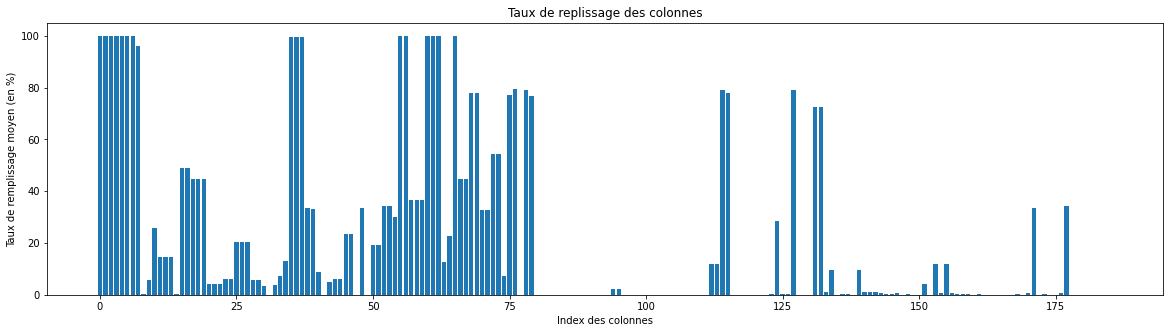

In [8]:
fig = plt.figure(figsize=(20,5))
plt.bar(range(0,len(inds_nan_rate)), inds_nan_rate*100)
plt.title("Taux de replissage des colonnes")
plt.xlabel("Index des colonnes")
plt.ylabel("Taux de remplissage moyen (en %)")
plt.show()

#### Supprimons les colonnes qui n'ont pas ou peu d'information sur lesquelles travailler

Commençons par regarder les colonnes complètement vides

In [9]:
cols_fillrate_00 = inds_nan_rate[inds_nan_rate == 0.00].index
cols_fillrate_00, len(cols_fillrate_00)

(Index(['cities', 'allergens_en', 'no_nutriments', 'additives',
        '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g',
        '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g',
        '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-acid_100g',
        '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-acid_100g',
        '-montanic-acid_100g', '-melissic-acid_100g',
        '-alpha-linolenic-acid_100g', '-eicosapentaenoic-acid_100g',
        '-docosahexaenoic-acid_100g', '-linoleic-acid_100g',
        '-arachidonic-acid_100g', '-gamma-linolenic-acid_100g',
        '-dihomo-gamma-linolenic-acid_100g', '-oleic-acid_100g',
        '-elaidic-acid_100g', '-gondoic-acid_100g', '-mead-acid_100g',
        '-erucic-acid_100g', '-nervonic-acid_100g', '-sucrose_100g',
        '-glucose_100g', '-fructose_100g', '-lactose_100g', '-maltose_100g',
        '-maltodextrins_100g'],
       dtype='object'),
 37)

Puis regardons les colonnes qui ont moins de 1% des données *(et plus de 0%)*

In [10]:
cols_fillrate_01 = inds_nan_rate[(inds_nan_rate > 0.00) & (inds_nan_rate < 0.01)].index
cols_fillrate_01, len(cols_fillrate_01)

(Index(['abbreviated_product_name', 'packaging_text', 'energy-from-fat_100g',
        'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g',
        'starch_100g', 'polyols_100g', 'soluble-fiber_100g',
        'insoluble-fiber_100g', 'casein_100g', 'serum-proteins_100g',
        'nucleotides_100g', 'beta-carotene_100g', 'vitamin-d_100g',
        'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-b6_100g',
        'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g', 'biotin_100g',
        'pantothenic-acid_100g', 'silica_100g', 'bicarbonate_100g',
        'chloride_100g', 'phosphorus_100g', 'magnesium_100g', 'zinc_100g',
        'copper_100g', 'manganese_100g', 'fluoride_100g', 'selenium_100g',
        'chromium_100g', 'molybdenum_100g', 'iodine_100g', 'caffeine_100g',
        'taurine_100g', 'ph_100g', 'fruits-vegetables-nuts_100g',
        'fruits-vegetables-nuts-dried_100g',
        'fruits-vegetables-nuts-estimate_100g',
        'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'ch

Et regardons les colonnes qui ont moins de 10% des données *(et plus de 1%)*

In [11]:
cols_fillrate_02 = inds_nan_rate[(inds_nan_rate > 0.01) & (inds_nan_rate < 0.2)].index
cols_fillrate_02, len(cols_fillrate_02)

(Index(['generic_name', 'packaging', 'packaging_tags', 'packaging_en',
        'origins', 'origins_tags', 'origins_en', 'manufacturing_places',
        'manufacturing_places_tags', 'emb_codes', 'emb_codes_tags',
        'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores',
        'allergens', 'traces', 'traces_tags', 'traces_en', 'additives_tags',
        'additives_en', 'brand_owner', 'energy-kj_100g',
        'monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
        'trans-fat_100g', 'cholesterol_100g', 'alcohol_100g', 'vitamin-a_100g',
        'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g',
        'vitamin-pp_100g', 'potassium_100g', 'calcium_100g', 'iron_100g'],
       dtype='object'),
 36)

En parcourant les colonnes identifiées dans ces trois selections, aucune ne me semble être

> Donc si on supprime les colonnes qui ont un taux de remplissage inférieur à 10%, on allège le jeu de données de 117 colonnes *(37+55+25)*.

In [12]:
cols_to_remove = inds_nan_rate[inds_nan_rate < 0.25].index
cols_to_remove, len(cols_to_remove)

(Index(['abbreviated_product_name', 'generic_name', 'packaging',
        'packaging_tags', 'packaging_en', 'packaging_text', 'origins',
        'origins_tags', 'origins_en', 'manufacturing_places',
        ...
        'carbon-footprint_100g', 'carbon-footprint-from-meat-or-fish_100g',
        'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
        'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
        'inositol_100g', 'carnitine_100g'],
       dtype='object', length=134),
 134)

In [13]:
for i, col_name in enumerate(cols_to_remove):
    print(i, col_name)

0 abbreviated_product_name
1 generic_name
2 packaging
3 packaging_tags
4 packaging_en
5 packaging_text
6 origins
7 origins_tags
8 origins_en
9 manufacturing_places
10 manufacturing_places_tags
11 labels
12 labels_tags
13 labels_en
14 emb_codes
15 emb_codes_tags
16 first_packaging_code_geo
17 cities
18 cities_tags
19 purchase_places
20 stores
21 allergens
22 allergens_en
23 traces
24 traces_tags
25 traces_en
26 serving_size
27 serving_quantity
28 no_nutriments
29 additives
30 additives_tags
31 additives_en
32 brand_owner
33 ecoscore_score
34 energy-kj_100g
35 energy-from-fat_100g
36 -butyric-acid_100g
37 -caproic-acid_100g
38 -caprylic-acid_100g
39 -capric-acid_100g
40 -lauric-acid_100g
41 -myristic-acid_100g
42 -palmitic-acid_100g
43 -stearic-acid_100g
44 -arachidic-acid_100g
45 -behenic-acid_100g
46 -lignoceric-acid_100g
47 -cerotic-acid_100g
48 -montanic-acid_100g
49 -melissic-acid_100g
50 monounsaturated-fat_100g
51 polyunsaturated-fat_100g
52 omega-3-fat_100g
53 -alpha-linolenic-ac

> Donc si on supprime les colonnes qui ont un taux de remplissage inférieur à 25%, on allège le jeu de données de 134 colonnes.
> 
> Ce qui le porterait de 186 à 52 colonnes.

#### Appliquons cette réduction et voyons si un tel jeu de données pourrait être utile.

In [14]:
cols_to_load = set(prob.columns) - set(cols_to_remove)
cols_to_load

{'additives_n',
 'brands',
 'brands_tags',
 'carbohydrates_100g',
 'categories',
 'categories_en',
 'categories_tags',
 'code',
 'countries',
 'countries_en',
 'countries_tags',
 'created_datetime',
 'created_t',
 'creator',
 'ecoscore_grade',
 'energy-kcal_100g',
 'energy_100g',
 'fat_100g',
 'fiber_100g',
 'food_groups',
 'food_groups_en',
 'food_groups_tags',
 'fruits-vegetables-nuts-estimate-from-ingredients_100g',
 'image_ingredients_small_url',
 'image_ingredients_url',
 'image_nutrition_small_url',
 'image_nutrition_url',
 'image_small_url',
 'image_url',
 'ingredients_tags',
 'ingredients_text',
 'last_modified_datetime',
 'last_modified_t',
 'main_category',
 'main_category_en',
 'nova_group',
 'nutriscore_grade',
 'nutriscore_score',
 'nutrition-score-fr_100g',
 'pnns_groups_1',
 'pnns_groups_2',
 'product_name',
 'proteins_100g',
 'quantity',
 'salt_100g',
 'saturated-fat_100g',
 'sodium_100g',
 'states',
 'states_en',
 'states_tags',
 'sugars_100g',
 'url'}

In [15]:
data = pd.read_csv(filename, sep='\t', dtype=dtypes, usecols=cols_to_load)

In [ ]:
data.shape

In [ ]:
df.head(3)

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
data.describe().T

In [ ]:
data.describe(exclude='number').T

In [ ]:
for i, c in enumerate(df.columns):
    print(i, c)

## Valeurs manquantes
Avec ce premier aperçu, on remarque qu'il est difficile d'avoir une bonne vision du jeu de données en raison du grand nombre de colonnes. Il serait donc intéressant de vérifier le taux de remplissage des colonnes pour éliner celles qui n'ont vraiment aucun espoir d'être imputées.

#### Affichons les valeurs manquantes pour chaque colonne

In [ ]:
import missingno as msno
msno.matrix(data, sort="ascending")

> Visiblement, il manque beaucoup de valeurs...

#### Affichons les taux de valeurs manquantes pour chaque colonne.

In [ ]:
# Définissons une fonction qui nous permet d'afficher 
# facilement le nombre de valeurs manquantes et leur taux

def print_missing_counts(dataset, col_array):
    missing_count = dataset[col_array].isnull().sum()
    missing_ratio = missing_count/dataset.shape[0]*100.0
    
    for k, v in zip(missing_count.keys(), missing_count):
        fraction = v/dataset.shape[0]*100.0
        print(f"{k.rjust(45)} is missing {v:6} values \t -->   {fraction:6.2f}%")
    return missing_ratio

In [ ]:
missing_ratio = print_missing_counts(data, data.columns)

> On constate qu'il y a de nombreuses colonnes pour lesquelles il manque 100% des valeurs.
>
> Mais il y en a aussi beaucoup d'autre avec des taux très élevés.

#### Identifions les colonnes pour lesquelles on à moins de 75% de valeurs manquantes.

In [ ]:
max_missing_rate = 90.0

In [ ]:
selected_cols = []
removed_cols = []

for name, value in missing_ratio.iteritems():
    if value < max_missing_rate:
        selected_cols.append(name)
    else:
        removed_cols.append(name)

In [ ]:
print(f"{len(selected_cols)} SELECTED COLS:\n {selected_cols}")

In [ ]:
print(f"{len(removed_cols)} REMOVED COLS:\n {removed_cols}")

In [ ]:
data.emb_codes.value_counts()

In [ ]:
data.allergens.value_counts()

In [ ]:
data.traces.value_counts()

#### Préparons une copie du dataset qui ne contient que les colonnes retenues

In [ ]:
data_low = data[selected_cols]

In [ ]:
msno.matrix(data_low, sort="ascending")

#### Et comparons le avec le dataset correspondant aux colonnes mises de côté

In [ ]:
data_low_removed = data[removed_cols]

In [ ]:
msno.matrix(data_low_removed, sort="ascending")

#### Et relançons l'analyse

In [ ]:
data_low.shape

In [ ]:
data_low.describe().T

In [ ]:
data_low.describe(exclude='number').T

In [ ]:
data.states

In [ ]:
data.states.iat[0]

In [ ]:
msno.matrix(data[['states', 'states_fr', 'states_tags']], sort="ascending")

In [ ]:
data.states_fr

In [ ]:
# nombre de lignes à charger en même temps en mémoire
chunksize = 10 ** 4
filename = 'data/fr.openfoodfacts.org.products.csv'
nan_rates = []
for chunk in pd.read_csv(filename, chunksize=chunksize, sep='\t'):
    nan_rates.append(chunk.isna().mean(axis=0))
# moyenne des taux de remplissage des chunks
inds_nan_rate = pd.concat(nan_rates, axis=1).mean(axis=1)
cols_to_load = inds_nan_rate[inds_nan_rate < 0.7].index.tolist()
df = pd.read_csv(filename, sep='\t', usecols=cols_to_load)

In [ ]:
df.describe()

In [ ]:
df.shape